In [1]:
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df_train = pd.read_csv("RawData/train.csv")
df_test = pd.read_csv("RawData/test.csv")

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

# Train_Word_Match

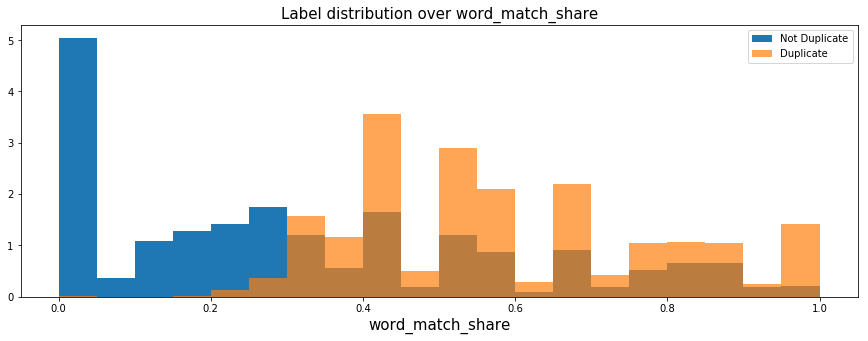

In [2]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

train_word_match = df_train.apply(word_match_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.show()

# Train_Word_Match_OnlyStops

In [ ]:
def PreprocessLemWithStops(Doc):
    tokens = nltk.wordpunct_tokenize(Doc)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    lemmer = WordNetLemmatizer()
    words = list(pd.Series(words).apply(lemmer.lemmatize))
    
    return words

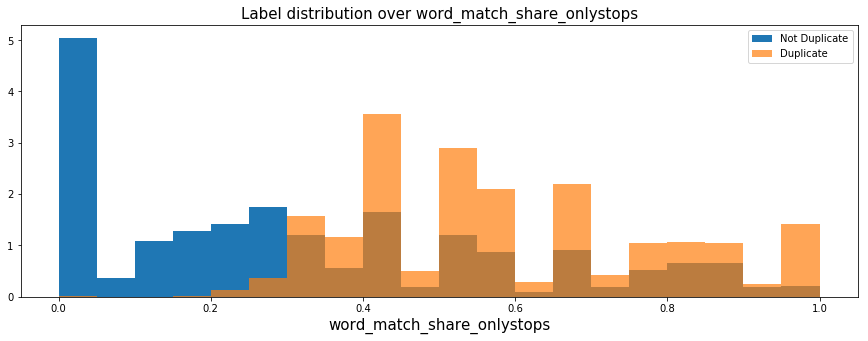

In [4]:

from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share_onlystops(row):
    if pd.isnull(row['question1']) or pd.isnull(row['question2']):
        return 0
    else:
        q1words = PreprocessLemWithStops(row['question1'])
        q2words = PreprocessLemWithStops(row['question2'])

        q1stops = {}
        q2stops = {}

        for word in q1words:
            if word in stops:
                q1stops[word] = 1
        for word in q2words:
            if word in stops:
                q2stops[word] = 1


        if len(q1stops) == 0 or len(q2stops) == 0:
            # The computer-generated chaff includes a few questions that are nothing but stopwords
            return 0
        shared_stops_in_q1 = [w for w in q1stops.keys() if w in q2stops]
        shared_stops_in_q2 = [w for w in q2stops.keys() if w in q1stops]
        R = (len(shared_stops_in_q1) + len(shared_stops_in_q2))/(len(q1stops) + len(q2stops))
        return R

train_word_match_onlystops = df_train.apply(word_match_share_onlystops, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share_onlystops', fontsize=15)
plt.xlabel('word_match_share_onlystops', fontsize=15)
plt.show()

# Tfidf_Train_Word_Match

In [8]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


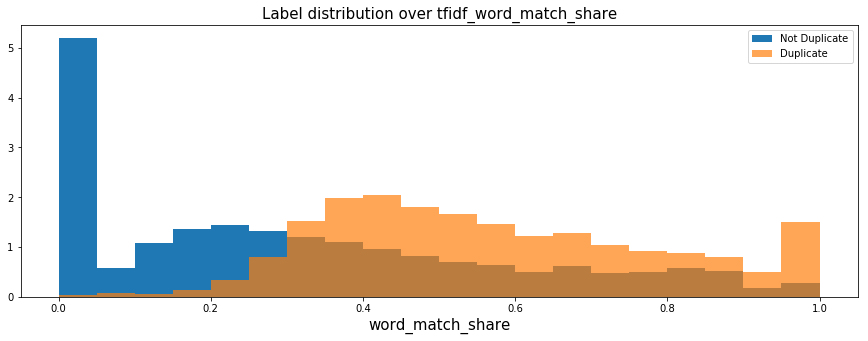

In [9]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

tfidf_train_word_match = df_train.apply(tfidf_word_match_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[df_train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.show()

# Laplace
$$Pi = (Tf + 1)\ /\ (DocLen +　UniqueTokens) $$

In [10]:
##The whole process of prepocessing a document(stemming and remove stop words)
from nltk.stem.lancaster import LancasterStemmer
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

def PreprocessDocLem(Doc):
    """return a term list"""
    lemmer = WordNetLemmatizer()
    terms = list(pd.Series(word_tokenize(Doc)).apply(lemmer.lemmatize))
    return terms

In [40]:
## generate q1 From q2(document = coupus)
from collections import Counter

def LaplaceForRow(row):
    if not pd.isnull(row['question2']) and not pd.isnull(row['question1']): 
        q1Li = PreprocessDocLem(row['question1'])
        q2Li = PreprocessDocLem(row['question2'])
        DocLen = len(q2Li)
        UniTokenLen = len(set(q2Li))
        TfCounter = Counter(q2Li)
        UniTokes = set(q2Li)
        LaplaceLi = []
        
        for term in list(set(q1Li)):
            if term in list(set(q2Li)):
                tf = TfCounter[term]
            else:
                tf = 0
            LaplaceLi.append(-np.log((tf+1)/(DocLen+UniTokenLen)))
#             LaplaceLi.append((tf+1)/(DocLen+UniTokenLen))

#         row['laplace'] = np.prod(LaplaceLi)*(10**10)
#         row['laplace'] = sum(LaplaceLi)
        return sum(LaplaceLi)

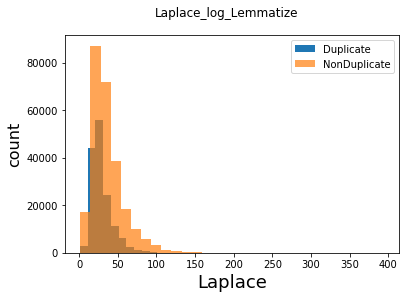

In [14]:
df_laplace = df_train.drop(['id','qid1','qid2'],axis=1)

df_laplace['laplace'] = None
# df_laplace.head()
df_laplace = df_laplace.apply(LaplaceForRow,axis=1)


plt.hist(df_laplace[df_train['is_duplicate']==1], bins=30, label='Duplicate')
plt.hist(df_laplace[df_train['is_duplicate']==0], bins=30, alpha=0.7,label ='NonDuplicate')
plt.xlabel('Laplace', fontsize=18)
plt.ylabel('count', fontsize=16)
plt.suptitle('Laplace_log_Lemmatize')

plt.legend()
plt.savefig('Laplace_log_Lemmatize')
plt.show()

# BM25

In [18]:
def PreprocessLemWithStops(Doc):
    tokens = nltk.wordpunct_tokenize(Doc)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    lemmer = WordNetLemmatizer()
    words = list(pd.Series(words).apply(lemmer.lemmatize))
    return words

In [23]:
## For train dataset
QuestionTermsLists = train_qs.apply(PreprocessLemWithStops)

QuestionTermsList = []
for termlist in QuestionTermsLists:
    QuestionTermsList += termlist
QuestionTermLSet = set(QuestionTermsList)

QuestionLength = len(QuestionTermsLists)

TermCountDict = {}
for term in QuestionTermLSet:
    TermCountDict[term] = 0

for TermsList in QuestionTermsLists:
    for term in set(TermsList):
        TermCountDict[term] += 1

IdfDict = {}
for term in QuestionTermLSet:
    IdfDict[term] = (QuestionLength - TermCountDict[term] +0.5)/ (TermCountDict[term] + 0.5)

AverageDocLen = len(QuestionTermsList)/len(df_train)    



In [24]:
from numpy import dot
from numpy.linalg import norm
def cosine(vector1, vector2):
    """ related documents j and q are in the concept space by comparing the vectors : cosine  = ( V1 * V2 ) / ||V1|| x ||V2|| """
    if norm(vector1) * norm(vector2) != 0:
        return float(dot(vector1,vector2) / (norm(vector1) * norm(vector2)))
    else:
        return 0

In [25]:
def BM25(row):
    if pd.isnull(row['question1']) or pd.isnull(row['question2']):
        return 0 
    else:
        q1words = PreprocessLemWithStops(row['question1'])
        q1Len = len(q1words)
        q2words = PreprocessLemWithStops(row['question2'])
        q2Len = len(q2words)

        vector = set(q1words+q2words)

        if len(q1words) == 0 or len(q2words) == 0:
            return 0
        else:
            q1TfDict = dict(Counter(q1words))
            q2TfDict = dict(Counter(q2words))
            q1vector = []
            q2vector = []

            for term in vector:
                termIdf = IdfDict[term]
                q1Tf = q1TfDict.get(term,0)
                q2Tf = q2TfDict.get(term,0)
                q1TfIdf = termIdf * ((3*q1Tf)/(q1Tf+0.5+1.5*(q1Len/AverageDocLen)))
                q2TfIdf = termIdf * ((3*q2Tf)/(q2Tf+0.5+1.5*(q2Len/AverageDocLen)))
                q1vector.append(q1TfIdf)
                q2vector.append(q2TfIdf)
            cosineScore = cosine(q1vector,q2vector)
        return cosineScore

In [ ]:
IdfDict = BM25Prepare(Train=True)
train_Bm25 = df_train.apply(BM25, axis=1, raw=True) 


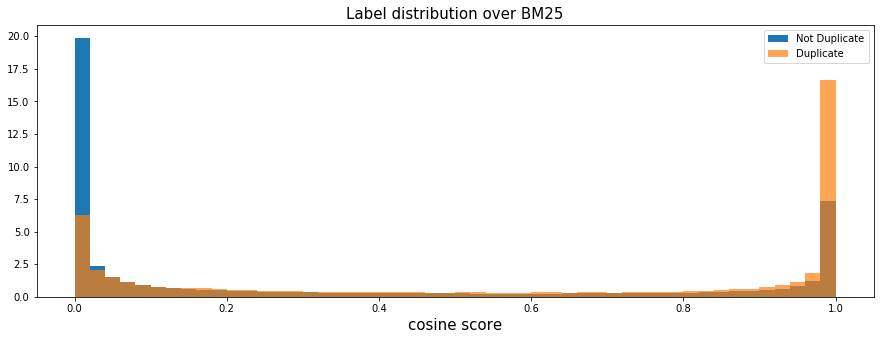

In [27]:
plt.figure(figsize=(15, 5))
plt.hist(train_Bm25[df_train['is_duplicate'] == 0], bins=50, normed=True, label='Not Duplicate')
plt.hist(train_Bm25[df_train['is_duplicate'] == 1], bins=50, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over BM25', fontsize=15)
plt.xlabel('cosine score', fontsize=15)
plt.show()

# Word mover's distance(Word2Vec)

In [28]:
import gensim
import matplotlib.pyplot as plt
import math

## You should first download pretrained models online
model = gensim.models.Word2Vec.load("D:\WikiCorpus\WikiModel\wiki.en.word2vec.model")

c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
import nltk
def PreprocessWithStops(Doc):
    tokens = nltk.wordpunct_tokenize(Doc)
    text = nltk.Text(tokens)
    wordsWithStops = [w.lower() for w in text]
    wordsInVocab = [term for term in wordsWithStops if term in model.wv.vocab]

    return wordsInVocab

def wmdDistance(row):
    Doc1 = row['question1']
    Doc2 = row['question2']
    if pd.isnull(Doc1) or pd.isnull(Doc2):
        return np.inf
    else:
        Doc1Li = PreprocessWithStops(Doc1)
        Doc2Li = PreprocessWithStops(Doc2)

        distance = model.wmdistance(Doc1Li, Doc2Li)
        return distance

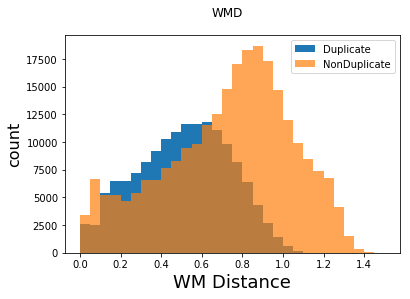

In [30]:
wmd_train = df_train.apply(wmdDistance,axis=1)

plt.hist(wmd_train[df_train['is_duplicate']==1], bins=30, label='Duplicate',range=(0,1.5))
plt.hist(wmd_train[df_train['is_duplicate']==0], bins=30, alpha=0.7,label ='NonDuplicate',range=(0,1.5))
plt.xlabel('WM Distance', fontsize=18)
plt.ylabel('count', fontsize=16)
plt.suptitle('WMD')

plt.legend()
# plt.savefig('Pic/WMD_WithStops')
plt.show()

# Edit Distance

In [31]:
def PreprocessLemWithStops(Doc):
    tokens = nltk.wordpunct_tokenize(Doc)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    lemmer = WordNetLemmatizer()
    words = list(pd.Series(words).apply(lemmer.lemmatize))
    return words

In [32]:
from Levenshtein import seqratio
def EditDistance(row):
    Doc1 = row['question1']
    Doc2 = row['question2']
    if pd.isnull(Doc1) or pd.isnull(Doc2):
        return np.inf
    else:
        Doc1Li = PreprocessLemWithStops(Doc1)
        Doc2Li = PreprocessLemWithStops(Doc2)

        distance = seqratio(Doc1Li, Doc2Li)
        return distance

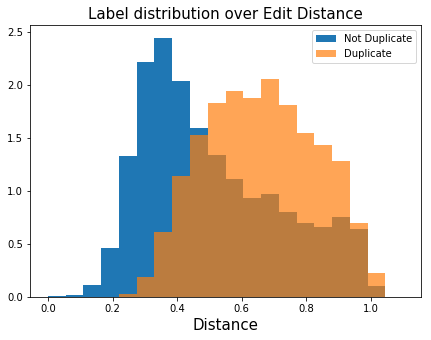

In [33]:
train_ED = df_train.apply(EditDistance, axis=1, raw=True) 

plt.figure(figsize=(7, 5))
plt.hist(train_ED[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate',range=(0,1.1))
plt.hist(train_ED[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate',range=(0,1.1))
plt.legend()
plt.title('Label distribution over Edit Distance', fontsize=15)
plt.xlabel('Distance', fontsize=15)
plt.show()

# Final Evaluation(XGBoost)

In [34]:
import pandas as pd
from matplotlib import pylab as plt
import numpy as np


df_train = pd.read_csv("RawData/train.csv")
df_test = pd.read_csv("RawData/test.csv")

train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)

In [50]:
import pandas as pd
import datetime

# x_train = pd.DataFrame()
# x_train['word_match'] = train_word_match
# x_train['word_match_onlystops'] = train_word_match_onlystops
# x_train['tfidf_word_match'] = tfidf_train_word_match
# x_train['laplace'] = df_laplace
# x_train['BM25'] = train_Bm25
# x_train['wm_distance'] = wmd_train
# x_train['ED'] = train_ED    ##Edit Distance


# nowtime = datetime.datetime.now()
# date = str(nowtime.date()).replace("-","")
# hour = str(nowtime.time()).split(':')[0]
# min = str(nowtime.time()).split(':')[1]
# x_train.to_csv('x_train'+date+hour+min+'.csv', index=False)

x_train = pd.read_csv("x_train201706292313.csv")

In [41]:
# ## for test dataset(BM25 Preparation)
# QuestionTermsLists = test_qs.apply(PreprocessLemWithStops)

# QuestionTermsList = []
# for termlist in QuestionTermsLists:
#     QuestionTermsList += termlist
# QuestionTermLSet = set(QuestionTermsList)

# QuestionLength = len(QuestionTermsLists)

# TermCountDict = {}
# for term in QuestionTermLSet:
#     TermCountDict[term] = 0

# for TermsList in QuestionTermsLists:
#     for term in set(TermsList):
#         TermCountDict[term] += 1

# IdfDict = {}
# for term in QuestionTermLSet:
#     IdfDict[term] = (QuestionLength - TermCountDict[term] +0.5)/ (TermCountDict[term] + 0.5)

# AverageDocLen = len(QuestionTermsList)/len(df_test)   

In [51]:
# x_test = pd.DataFrame()
# x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
# x_test['word_match_onlystops'] = df_test.apply(word_match_share_onlystops, axis=1, raw=True)
# x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)
# x_test['laplace'] = df_test.apply(LaplaceForRow, axis=1, raw=True)
# x_test['BM25'] = df_test.apply(BM25, axis=1, raw=True)
# x_test['wm_distance'] = df_test.apply(wmdDistance, axis=1, raw=True)
# x_test['ED'] = df_test.apply(EditDistance, axis=1, raw=True)

# nowtime = datetime.datetime.now()
# date = str(nowtime.date()).replace("-","")
# hour = str(nowtime.time()).split(':')[0]
# min = str(nowtime.time()).split(':')[1]
# x_test.to_csv('x_test'+date+hour+min+'.csv', index=False)

x_test = pd.read_csv("x_test201706291910.csv")

In [52]:
y_train = df_train['is_duplicate'].values

# Rebalance
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]


p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])    ##concat: Add rows
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [53]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [54]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
## learning rate: Lower values generalize well.
params['max_depth'] = 8
## control over-fitting, higher depth specific to a particular sample.

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.672344	valid-logloss:0.672477
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.530196	valid-logloss:0.531463
[20]	train-logloss:0.454235	valid-logloss:0.456335
[30]	train-logloss:0.409618	valid-logloss:0.412437
[40]	train-logloss:0.382099	valid-logloss:0.385616
[50]	train-logloss:0.364801	valid-logloss:0.368873
[60]	train-logloss:0.353867	valid-logloss:0.358406
[70]	train-logloss:0.346521	valid-logloss:0.351481
[80]	train-logloss:0.34166	valid-logloss:0.346967
[90]	train-logloss:0.338233	valid-logloss:0.343935
[100]	train-logloss:0.335773	valid-logloss:0.341804
[110]	train-logloss:0.33402	valid-logloss:0.340333
[120]	train-logloss:0.332768	valid-logloss:0.33934
[130]	train-logloss:0.331772	valid-logloss:0.338593
[140]	train-logloss:0.330961	valid-logloss:0.337999
[150]	train-logloss:0.330305	valid-logloss:0.337582
[160]	train-logloss:0.329632	va

In [55]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test

nowtime = datetime.datetime.now()
date = str(nowtime.date()).replace("-","")
hour = str(nowtime.time()).split(':')[0]
min = str(nowtime.time()).split(':')[1]
sub.to_csv('submission'+date+hour+min+'.csv', index=False)